## Gated Recurrent Units (GRU)

The gated recurrent unit (GRU) offered a streamlined version of the LSTM memory cell that often achieves comparable performance but with the advantage of being faster to compute.

### Reset Gate and Update Gate

The LSTM's three gates are replaced by two: 

* reset gate 
* update gate. 
  
As with LSTMs, these gates are given sigmoid activations, forcing their values to lie in the interval $(0,1)$. 

Intuitively, the **reset gate** controls how much of the previous state we might still want to remember. Likewise, an **update gate** would allow us to control how much of the new state is just a copy of the old state. The figure below illustrates the inputs for both the reset and update gates in a GRU, given the input of the current time step and the hidden state of the previous time step. The outputs of two gates are given by two fully connected layers with a sigmoid activation function.

<center>

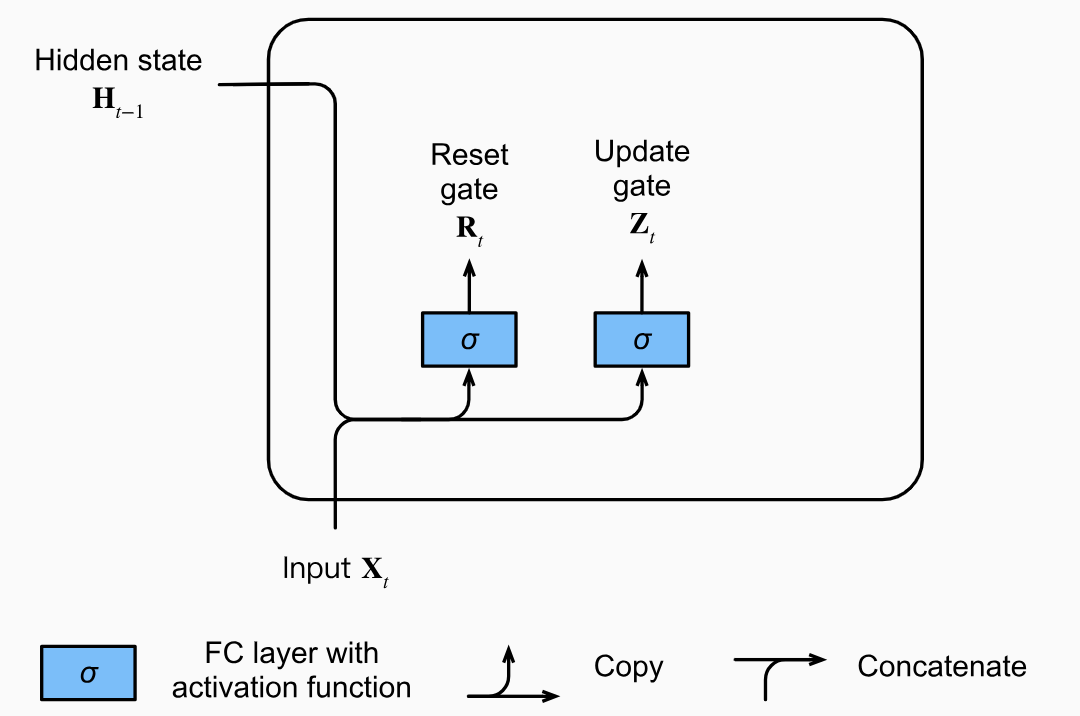

</center>

### Update Rules for Reset and Update Gates

For a given time step $t$, suppose that the input is a minibatch $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ (number of examples: $n$, number of inputs: $d$) and the hidden state of the previous time step is $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$ (number of hidden units: $h$). Then, the reset gate $\mathbf{R}_t \in \mathbb{R}^{n \times h}$ and update gate $\mathbf{Z}_t \in \mathbb{R}^{n \times h}$ are computed as follows:

$$
\begin{aligned}
\mathbf{R}_t & =\sigma\left(\mathbf{X}_t \mathbf{W}_{x r}+\mathbf{H}_{t-1} \mathbf{W}_{h r}+\mathbf{b}_r\right) \\
\mathbf{Z}_t & =\sigma\left(\mathbf{X}_t \mathbf{W}_{x z}+\mathbf{H}_{t-1} \mathbf{W}_{h z}+\mathbf{b}_z\right)
\end{aligned}
$$

where 

* $\mathbf{W}_{x r}, \mathbf{W}_{x z} \in \mathbb{R}^{d \times h}$ 
* $\mathbf{W}_{h r}, \mathbf{W}_{h z} \in \mathbb{R}^{h \times h}$ are the weight parameters
* $\mathbf{b}_r, \mathbf{b}_z \in \mathbb{R}^{1 \times h}$ are the (broadcasted) bias parameters

### Candidate Hidden State

Next, we integrate the reset gate $\mathbf{R}_t$ with the regular updating mechanism of RNNs, leading to the following candidate hidden state $\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}$ at time step $t$:

$$
\tilde{\mathbf{H}}_t=\tanh \left(\mathbf{X}_t \mathbf{W}_{x h}+\textcolor{red}{\left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{h h}}+\mathbf{b}_h\right)
$$

where 

* $\mathbf{W}_{x h} \in \mathbb{R}^{d \times h}$
* $\mathbf{W}_{h h} \in \mathbb{R}^{h \times h}$ are the weight parameters
* $\mathbf{b}_h \in \mathbb{R}^{1 \times h}$ is the (broadcasted) bias

The symbol $\odot$ is the Hadamard (elementwise) product operator. In addition, we use a tanh activation function.

The result is a candidate, since we still need to incorporate the action of the update gate. Comparing with the vanilla RNN update, now the influence of the previous states can be reduced with the elementwise multiplication of $\mathbf{R}_t$ and $\mathbf{H}_{t-1}$ in the equation above. 

Whenever the entries in the reset gate $\mathbf{R}_t$ are close to 1, we recover a vanilla RNN. For all entries of the reset gate $\mathbf{R}_t$ that are close to 0, the candidate hidden state is the result of an MLP with $\mathbf{X}_t$ as input (red term goes to zero). Any preexisting hidden state is thus reset to defaults.

<center>

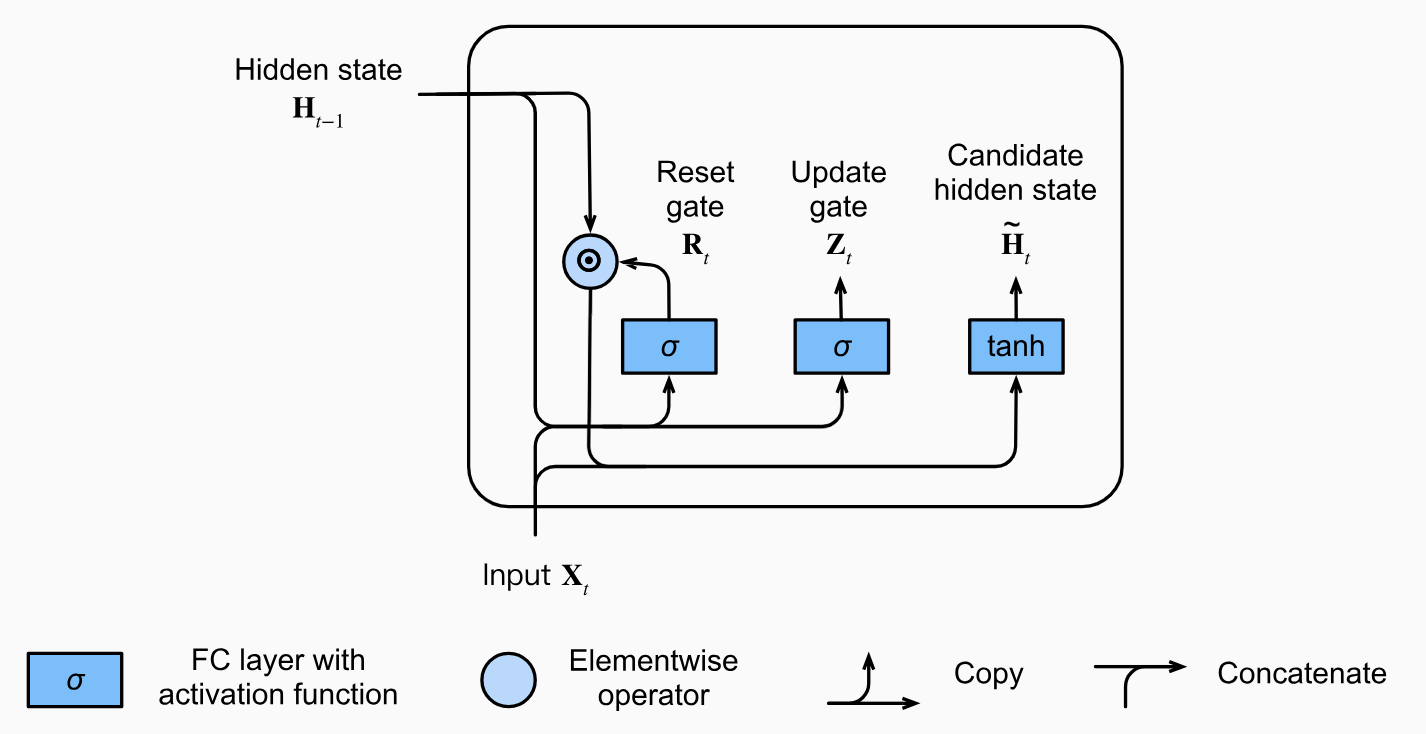

</center>

### Hidden State

Finally, we need to incorporate the effect of the update gate $\mathbf{Z}_t$. This determines the extent to which the new hidden state $\mathbf{H}_t \in \mathbb{R}^{n \times h}$ matches the old state $\mathbf{H}_{t-1}$ versus how much it resembles the new *candidate* state $\tilde{\mathbf{H}}_t$. 

The update gate $\mathbf{Z}_t$ can be used for this purpose, simply by taking elementwise convex combinations of $\mathbf{H}_{t-1}$ (previous hidden state) and $\tilde{\mathbf{H}}_t$ (candidate hidden state). This leads to the final update equation for the GRU:

$$
\mathbf{H}_t=\textcolor{red}{\mathbf{Z}_t \odot \mathbf{H}_{t-1}}+\textcolor{blue}{\left(1-\mathbf{Z}_t\right) \odot \tilde{\mathbf{H}}_t}
$$

* Whenever the update gate $\mathbf{Z}_t$ is close to 1, we simply retain the old state. In this case the information from $\mathbf{X}_t$ is ignored (blue term pushed to zero), effectively skipping time step $t$ in the dependency chain. 

* In contrast, whenever $\mathbf{Z}_t$ is close to 0, the new latent state $\mathbf{H}_t$ approaches the candidate latent state $\tilde{\mathbf{H}}_t$ as the red term goes to zero.

<center>

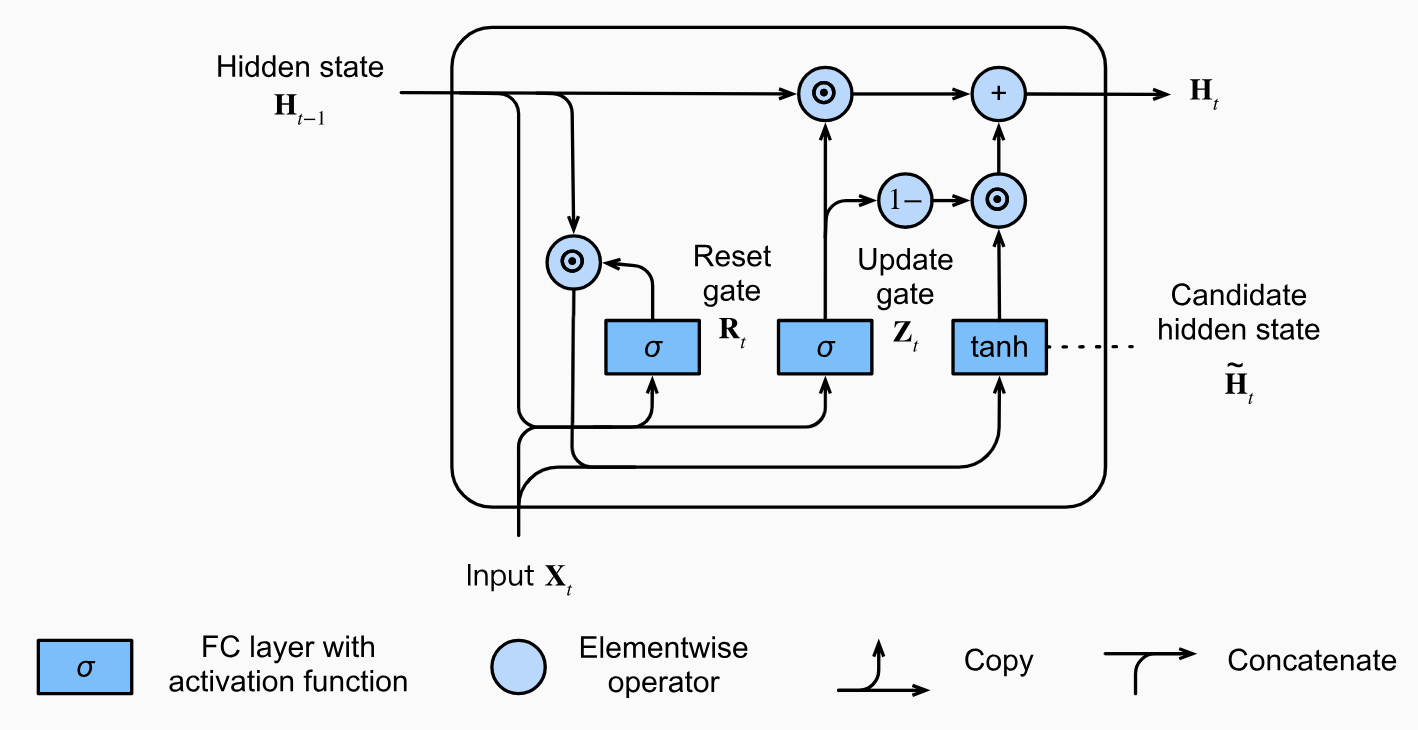

</center>

GRUs have the following two distinguishing features:

* Reset gates help capture short-term dependencies in sequences.

* Update gates help capture long-term dependencies in sequences.